## Meta-Critic Whisky Database - Exploration and Predictions

#### Visualisation and exploration of whisky database from https://whiskyanalysis.com/index.php/database/

This notebook uses the Scikit-learn https://scikit-learn.org/stable/index.html and Pandas https://pandas.pydata.org/ libraries in Python. The aim is to use a linear regression estimator from scikit-learn that will use Selfbuilt's whisky analysis database to learn the parameters that define the relationship between the characteristics of each whisky and its meta-critic score. It will then be possible to use this relationship to make predictions on the meta-critic scores of whiskies not in the database.

##### Procedure
1. Import libraries needed to perform analysis and instantiate the estimator
2. Read the data into a pandas data-frame
3. Examine the data, look at the distributions of the variables and conduct an exploratory analysis of how whisky characteristics affect its score
4. Organise (pre-process) the data so that it can be used in a sci-kit learn estimator
5. Instantiate and train the linear regression model
6. Evaluate the model's performance 
7. Use the model to make predictions on new whiskies 

#### 1. Getting started

In [1]:
import pandas as pd #to view and manipulate the data
import numpy as np #for the maths!
import matplotlib.pyplot as plt #for graphs and plots

In [2]:
%matplotlib inline

#### 2. Read data into pandas

In [67]:
df = pd.read_csv('whisky_analysis.csv') # creates a pandas data-frame object from the downloaded whisky database

#### 3. Look at the data

In [4]:
df.head() #first 5 rows

,Whisky,Meta Critic,STDEV,#,Cost,Class,Super Cluster,Cluster,Country,Type
0,Ledaig 42yo Dusgadh,9.47,0.25,3,$$$$$+,SingleMalt-like,ABC,C,Scotland,Malt
1,Glenfarclas 40yo,9.28,0.26,15,$$$$$+,SingleMalt-like,ABC,A,Scotland,Malt
2,Glengoyne 25yo,9.21,0.23,14,$$$$$+,SingleMalt-like,ABC,A,Scotland,Malt
3,Amrut Spectrum (Batch 1),9.19,0.24,10,$$$$$,SingleMalt-like,ABC,C,India,Malt
4,Highland Park 25yo,9.18,0.17,14,$$$$$+,SingleMalt-like,ABC,C,Scotland,Malt


In [5]:
#get rid of the spaces!
df.rename(columns={'Meta Critic':'Score','Super Cluster':'Super_Cluster'}, inplace=True)

In [6]:
# replace special character $ with £ 
df.Cost = df.Cost.str.replace('$','£')

In [7]:
df.head(2) #checking...

,Whisky,Score,STDEV,#,Cost,Class,Super_Cluster,Cluster,Country,Type
0,Ledaig 42yo Dusgadh,9.47,0.25,3,£££££+,SingleMalt-like,ABC,C,Scotland,Malt
1,Glenfarclas 40yo,9.28,0.26,15,£££££+,SingleMalt-like,ABC,A,Scotland,Malt


In [8]:
df.describe() # some stats

,Score,STDEV,#
count,1454.000000,1454.000000,1454.000000
mean,8.540199,0.372999,10.127235
std,0.390641,0.182573,5.671888
min,6.470000,0.020000,3.000000
25%,8.320000,0.260000,5.000000
50%,8.590000,0.340000,9.000000
75%,8.810000,0.450000,14.000000
max,9.470000,1.870000,28.000000


In [9]:
df.tail() # more checks - note, there is quite a lot of absent information: 'NaN'

,Whisky,Score,STDEV,#,Cost,Class,Super_Cluster,Cluster,Country,Type
1449,Jim Beam White Label,7.66,0.48,19,£,Bourbon-like,NaN,R2,USA,Bourbon
1450,Rebel Yell Kentucky Bourbon,7.46,0.54,12,£,Bourbon-like,NaN,R0,USA,Bourbon
1451,Jim Beam Red Stag (Black Cherry),7.43,0.95,4,£,Bourbon-like,NaN,NaN,USA,Flavoured
1452,Virginia Black,7.32,1.08,6,££,Bourbon-like,NaN,R2,USA,Bourbon
1453,Laphroaig Cairdeas 2018 Fino,9.00,0.13,4,NaN,NaN,NaN,NaN,NaN,NaN


#### Distributions of different whisky characteristics

Text(0,0.5,'Frequency')

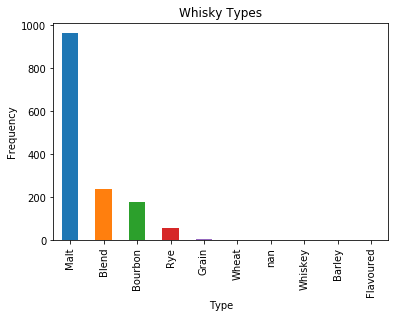

In [10]:
ax = df.Type.value_counts(dropna = False).plot.bar(title = 'Whisky Types')
ax.set_xlabel("Type")
ax.set_ylabel("Frequency")

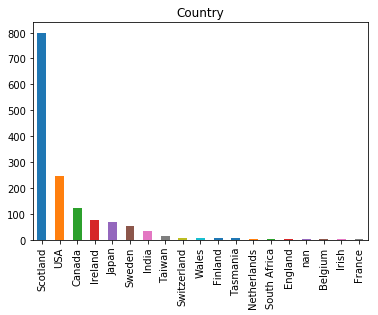

In [11]:
df.Country.value_counts(dropna = False).plot.bar(title = 'Country')

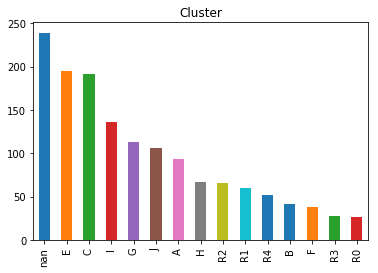

In [12]:
df.Cluster.value_counts(dropna = False).plot.bar(title = 'Cluster')

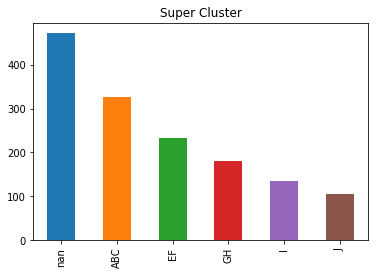

In [13]:
df['Super_Cluster'].value_counts(dropna = False).plot.bar(title = 'Super Cluster')

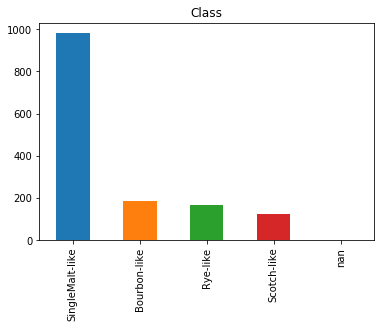

In [14]:
df.Class.value_counts(dropna = False).plot.bar(title = 'Class')

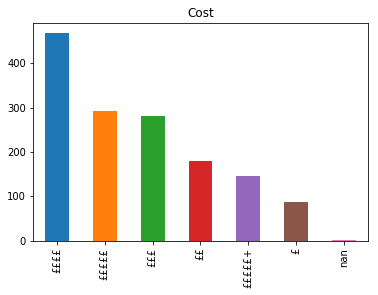

In [15]:
df.Cost.value_counts(dropna = False).plot(kind = 'bar', title = 'Cost')

##### Histograms of Meta Critic scores

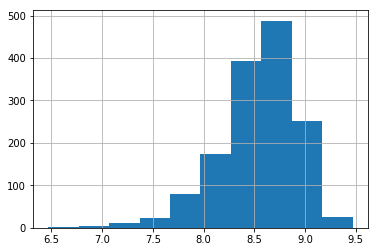

In [16]:
# for whole population
df.Score.hist()

##### Meta Critic distributions for differnet countries

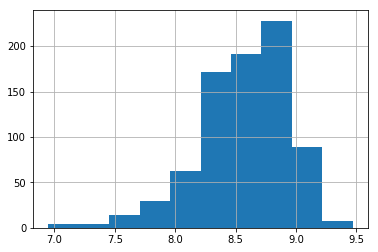

In [17]:
#Scotland
df.Score[df.Country == 'Scotland'].hist()

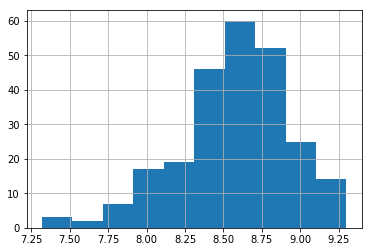

In [18]:
#USA
df.Score[df.Country == 'USA'].hist()

##### We can see that the score distribution for Scottish whiskies shows a predominance of higher scores compared with American ones.

#### Mean Meta Critic Scores by different characteristics

In [19]:
# Change figsize
fig_size = plt.rcParams["figure.figsize"]
#print ("Current size:", fig_size)
fig_size[0] = 6
fig_size[1] = 4

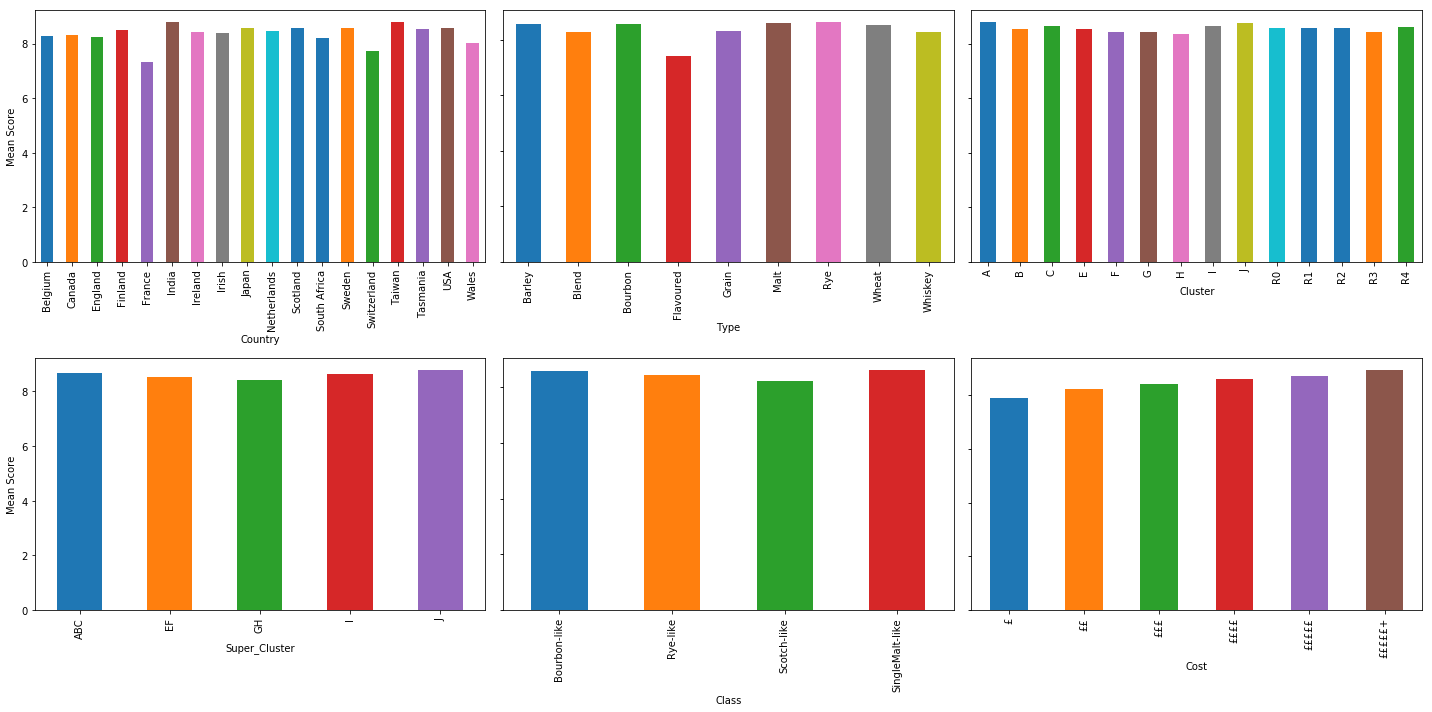

In [20]:
cols = ['Country','Type','Cluster','Super_Cluster','Class','Cost']
for i, value in enumerate(cols):
    plt.tight_layout()
    plt.subplot(2,3, i+1)
    df.groupby(value)['Score'].mean().plot.bar(sharey = 'row', figsize = (20,10)).set_ylabel('Mean Score')

#### Comments so far:
- 1453 Whiskies!
- Scottish malts significantly the most common
- Single malts by far the most common type

##### What indicators are there about predicting the score?
- French and Swiss whiskies have a lower mean!
- Flavoured whiskies have the lowest mean score
- Score increases with price, but not by much!

#### 4. Data preprocessing to run a linear regression model 

In [21]:
# Drop the 'Whisky', 'STDEV' and # columns as these aren't a factor in determining the score
df = df.drop(['Whisky', 'STDEV', '#'], axis=1)

In [22]:
df.head()

,Score,Cost,Class,Super_Cluster,Cluster,Country,Type
0,9.47,£££££+,SingleMalt-like,ABC,C,Scotland,Malt
1,9.28,£££££+,SingleMalt-like,ABC,A,Scotland,Malt
2,9.21,£££££+,SingleMalt-like,ABC,A,Scotland,Malt
3,9.19,£££££,SingleMalt-like,ABC,C,India,Malt
4,9.18,£££££+,SingleMalt-like,ABC,C,Scotland,Malt


In [23]:
# get rid of the missing data and replace with a blank string. 
#There are other ways to deal with missing data, for instance replace it with a column's 'most frequent value. However, we don't want to make any assumptions. 
df = df.fillna('')

In [24]:
#Check that NaN values have gone
df.isnull().sum() 

Score            0
Cost             0
Class            0
Super_Cluster    0
Cluster          0
Country          0
Type             0
dtype: int64

##### Now to organise the data into a format that can be used with a scikit-learn estimator...

We need to seperate the data into a feature matrix, X (the inputs) and a target vector, y (the outputs)

In [25]:
# the pop method will do the trick...
y = df.pop('Score')

In [26]:
X = df

In [27]:
y.shape

(1454,)

In [28]:
X.shape

(1454, 6)

Much of our data is categorical. We need to convert this to numerical data that our estimator can make calculations on. We use [One Hot Encoding](https://machinelearningmastery.com/why-one-hot-encode-data-in-machine-learning/) to convert the categorical variables to 1s and 0s.

In [29]:
#sci-kit learn has its own encoder...
from sklearn.preprocessing import OneHotEncoder

In [30]:
enc = OneHotEncoder()

In [31]:
X_encoded = enc.fit_transform(X).toarray() #X_encoded is now in encoded form

In [32]:
X_encoded.shape 

(1454, 62)

#### 5. Fit models and make predictions

In [33]:
# To evaluate our model to see how it will perform against unseen data, we split the data into 'test' and 'train' subsets. 
# The training data will be used by the model to learn the parameters. The testing data will be kept seperately to be used as an 'unseen' dataset to evaluate the model.
from sklearn.model_selection import train_test_split

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size = 0.2, random_state = 1) # random state for reproducibility

In [35]:
# the next 3 cells are commented out. An initial trial with the LinearRegression model produced a very large variance and so this was abandoned in favour of the Ridge model
#from sklearn.linear_model import LinearRegression

In [36]:
#reg = LinearRegression().fit(X_train, y_train)

In [37]:
#preds = reg.predict(X_test)

In [38]:
# use a linear regression model that utilises regularisation
# RidgeCV gives opportunity to try different regularisation parameters

from sklearn.linear_model import RidgeCV

In [39]:
#generate different reg parameters
alphas = np.arange(1, 6, 0.01)

In [40]:
rid = RidgeCV(alphas = alphas).fit(X_train, y_train) #the fit method learns the parameters for our model

In [43]:
#best reg parameter
rid.alpha_

2.0100000000000007

In [44]:
# make predictions on the test data
preds = rid.predict(X_test) 

In [45]:
# sanity check - do they look reasonable?
preds

array([8.03132583, 8.55178916, 7.78662943, 9.04296748, 8.60844448,
       8.31999471, 9.00499444, 9.01475518, 9.03125855, 8.77137996,
       8.52079879, 7.78662943, 8.52079879, 8.30709275, 8.34425249,
       8.37503771, 8.75293122, 8.85631883, 8.64640734, 8.74182674,
       8.66528554, 8.75293122, 8.86154013, 8.64640734, 8.50458416,
       7.99108281, 8.68809244, 8.37945578, 8.45205922, 8.24034675,
       8.08824393, 7.78662943, 8.49350139, 8.56528044, 7.78662943,
       8.11554133, 8.6008284 , 8.30709275, 8.08396149, 8.74182674,
       7.56381173, 7.99108281, 8.52684404, 9.11957623, 8.32803785,
       8.75293122, 8.04481711, 8.5648069 , 8.51154614, 8.91136757,
       8.27591641, 8.56349809, 8.50458416, 8.08824393, 8.70207135,
       8.12937866, 8.75293122, 8.53528578, 8.6353304 , 8.52079879,
       8.46986103, 7.99108281, 8.60844448, 8.46986103, 9.03125855,
       8.5648069 , 8.53528578, 8.34425249, 8.32803785, 8.48363906,
       8.64640734, 8.88453114, 8.48363906, 8.71183209, 8.55158

#### 6.Evaluate model performance

In [46]:
from sklearn.metrics import mean_absolute_error

In [47]:
mean_absolute_error(y_test, preds)

0.19083896840125109

In [48]:
from sklearn.metrics import r2_score

In [49]:
r2_score(y_test, preds)

0.6086347465754794

##### So we can predict meta-critic scores with an accuracy of approx 0.2!

#### 7. Make predictions for new whiskies!

In [50]:
#Let's try making a prediction on a fictitious whisky!
# Need fields ['Cost', 'Class', 'Super_Cluster','Cluster', 'Country', 'Type']
cols = ['Cost', 'Class', 'Super_Cluster','Cluster', 'Country', 'Type']

In [59]:
our_whisky = ['£££££+', 'SingleMalt-like', 'ABC', 'B', 'India', 'Malt']

In [60]:
our_df = pd.DataFrame([our_whisky], columns = cols)

In [61]:
our_df

,Cost,Class,Super_Cluster,Cluster,Country,Type
0,£££££+,SingleMalt-like,ABC,B,India,Malt


In [62]:
our_df.shape

(1, 6)

In [63]:
#vecotrize our_df
our_df_encoded = enc.transform(our_df).toarray()

In [64]:
our_df_encoded.shape

(1, 62)

In [65]:
our_prediction = rid.predict(our_df_encoded)

In [66]:
our_prediction[0]

9.019976473366954

##### So, an expensive single malt from India ranks in the top 25% of all whiskies!

#### 8. Conclusion

##### We have trained a linear regression estimator, RidgeCV from scikit-learn, to predict meta-critic scores from whisky characteristics. Mean error is ~0.2 and r^2 value is ~0.6

##### Further possible exploration:
- Currently price is treated as a categorical variable. The model infers no relationship between the different prices - only that they are different. Using [label encoding](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html) rather than one hot encoding on the price feature should be explored. It may also be possible to obtain better data on the prices.
- The way that NaN values are treated should be explored. For instance, whisky 1453, Laphroaig Cairdeas 2018 Fino, contains all NaNs but has a very high score. The presence of such examples will cause the estimator to reward the presence of NaN values. It may be better to delete whiskies that contain a high number of NaNs



Workbook and code written by Michael Farrell, Cambridge, UK. Github: https://github.com/michaelf736 LinkedIn: www.linkedin.com/in/michael-farrell-5b8b401 Comments, queries and general greetings very welcome.